# Notebook for Fruit Image classification
classification of fruit using fastai library (docs.fast.ai), which runs on top of pytorch

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

TODO provare a aggiungere altre metriche

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import CSVLogger
#from fastai.conv_learner import *
from pathlib import Path
import numpy as np

In [3]:
path_img = Path("dataset_classification")
batch_size = 64
np.random.seed(20) #random seed for reproduce results

create dataset object using a folder source folder formatted as `label1/* label2/* ..`. Do not use cross validation, split it 80% 20 % for training validation. Apply all fastai builtin transformations and normalize (still need to understand well what it does)

#### Commento di Roberto
1) Preferirei che lo script facesse la validazone non in base a quanto indicato con il parametro valid_pct, ma utilizzando le cartelle che hai già preparato (70% e 30% delle immagini), come indicato a questo link https://docs.fast.ai/vision.data.html#ImageDataBunch;

2) get_transforms(), siamo in grado di capire quanti samples vengono prodotti dal data aumentation di default?

3) il parametro 'size=224' immagino si riferisca al resize delle immagini (*provare a cambiare size*)

4) il parametro 'bs', a cosa si riferisce?

5) che tipo di normalizzazione viene applicata? Dobbiamo specificarlo

In [4]:
data = ImageDataBunch.from_folder(path_img,ds_tfms=get_transforms(), size=224, bs=batch_size).normalize(imagenet_stats)

In [5]:
data.classes

['Albicocca',
 'Banana',
 'Carota',
 'Cetriolo',
 'Champignon',
 'Ciliegia',
 'Cipolla',
 'Kiwi',
 'Lime',
 'Mela',
 'Patata',
 'Peperoncino',
 'Pera',
 'Pesca',
 'Prugna rossa',
 'Zucchino',
 'pomodoro_ciliegino',
 'pomodoro_sanmarzano']

#### Commento di Roberto
Come mai sembra che le immagini abbiano un riflesso speculare accanto ai bordi?
Cosa, in questo notebook che hai preparato, si occupa di tagliare l'immagine anzinché operare solo il resize?

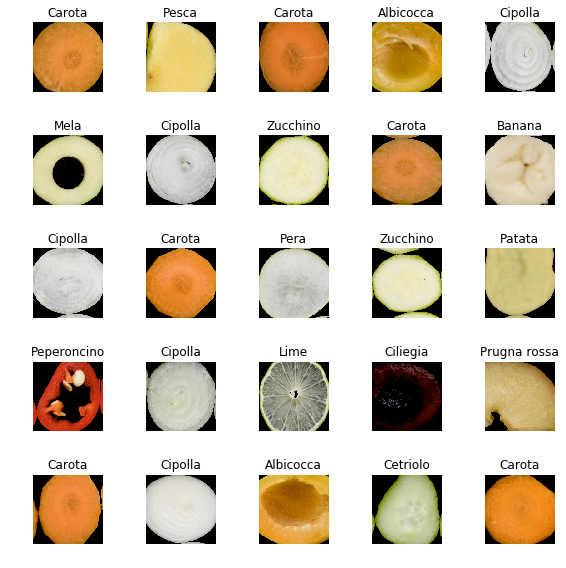

In [17]:
#show some images from dataset
data.show_batch(rows=5, figsize=(8,8))

create a model using renet34 pretrained on imagenet

In [18]:
learn = create_cnn(data, models.resnet34, metrics=[error_rate], callback_fns=[CSVLogger])

/opt/miniconda/envs/fastai/lib/python3.7/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [19]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


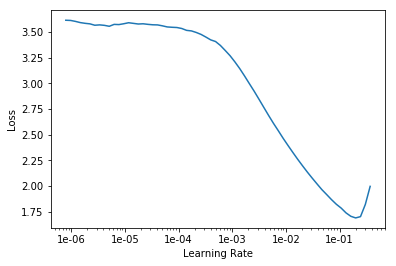

In [20]:
learn.recorder.plot()

#### Commento di Roberto
Qua ho esasperato un po' il numero di epoch
L'andamento del train_loss e del valid_loss andrebbe graficato, perché fornisce una chiara idea di possibili problemi di under/overfitting del modello.
Per comprendere meglio questa parte ti invito a leggere quanto segue, che spiega anche perché è possibile osservare un valore del valid_loss inferiore al train_loss:
https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error/187404#187404
Ovviamente, nella soluzione con 20 epochs ci troviamo in overfitting.

In [21]:
epochs = 3
lr = 1e-3
learn.fit_one_cycle(epochs, lr) #make 4 learning epoch

epoch,train_loss,valid_loss,error_rate,time
0,2.613217,0.786120,0.125000,00:08
1,1.327137,0.103287,0.013158,00:08
2,0.809798,0.080471,0.013158,00:08


after 3 learning epoch we have achieved a 0% error rate

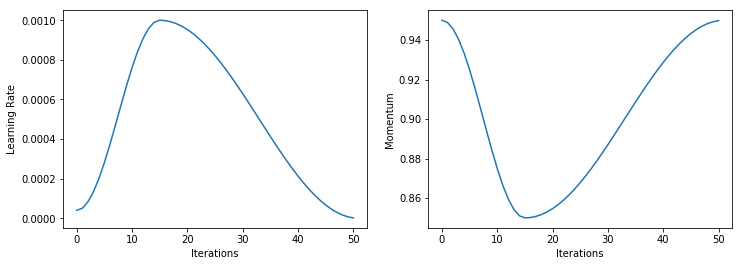

In [22]:
learn.recorder.plot_lr(show_moms=True)

Text(0, 0.5, 'Error rate')

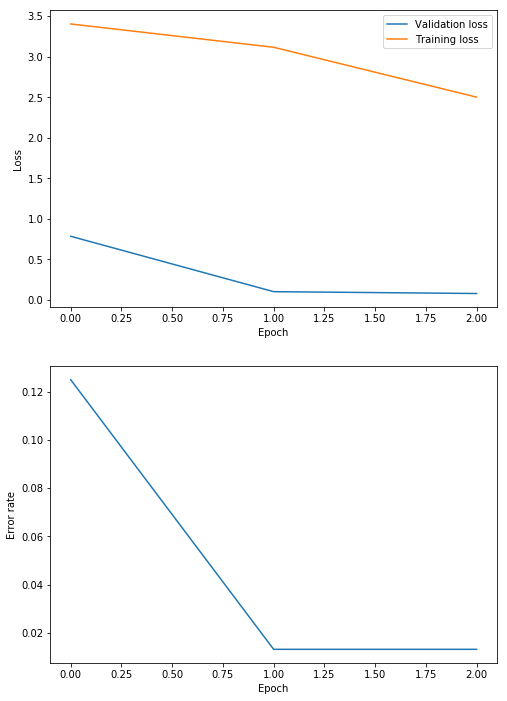

In [23]:
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(epochs)),learn.recorder.val_losses, label='Validation loss')
ax[0].plot(list(range(epochs)),[learn.recorder.losses[i] for i in range(epochs+2,epochs*(epochs+3),epochs+3)], label='Training loss')
#ax[0].plot(list(range(epochs)),[learn.recorder.losses[i] for i in range(0,len(learn.recorder.losses),epochs-3)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')
ax[1].plot(list(range(epochs)),learn.recorder.metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Error rate')

In [24]:
learn.save('stage-1', return_path=True)

PosixPath('dataset_classification/models/stage-1.pth')

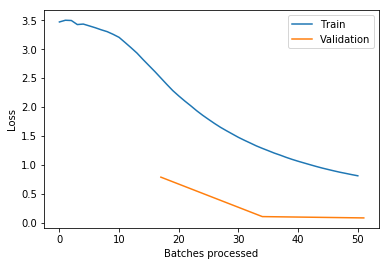

In [25]:
learn.recorder.plot_losses()

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

#### Commento di Roberto
Ho aggiunto questa nuova parte per ottenere una rappresentazione della matrice di confusione.
Analizzare l'andamento dell'error_rate è importante, ma non basta.
Come puoi vedere abbiamo un problema: il numero di campioni per le diverse classi è differente. Deduco che ciò sia dovuto al fatto che l'algoritmo seleziona in maniera totalmente randomica le classi.
Non è proprio il massimo, soprattutto perché sbagliare la classificazione di 1 albicocca su 20 ha un peso ben diverso dello sbagliare 1 carota su un totale di 53.
Il numero di elementi per classe andrebbe uniformato.

N.B. la matrice di confusione sottostante è stata ottenuta da un modello in overfitting

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=150)

In [ ]:
interp.most_confused(min_val=1)

#### Commento di Roberto
Dai uno sguardo a questo paragrafo https://docs.fast.ai/vision.learner.html#ClassificationInterpretation
La probability è molto importante per capire la capacità predittiva di un modello.
Per ogni singola immagine è possibile capire con quale probabilità questa è stata associata al label corretto.
Più è alto tale valore, più ovviamente il modello funziona bene.
Se guardi la prima immagine in alto a sx, la prugna rossa ha una probability del 57% di essere prugna rossa (non è proprio così eccelente).
Estrarre le metriche da ogni immagine e mediarle per classe, ci può aiutare a descrivere la bontà del modello per ogni classe di prodotto ed a migliorarlo di conseguenza (facendo per esempio il transfer learning su altre CNN).
Insomma, non ci dobbiamo fermare all'errore totale di predizione (o, viceversa, alla sola accuratezza media del modello, che corrisponde a 1 - error_rate)

In [ ]:
interp.plot_top_losses(9, figsize=(11,11))

#### Commento di Roberto
Dovremmo testare il modello sul test set che hai preparato nell'altra cartella e valutare le metriche su quelle immagini.

#### simone


provo a fare fine tuning

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5,slice(1e-5,3e-4))

con un sistema "manuale" provo tutte le immaggini del final_valid che lui non ha mai visto (sono 531) e ottengo un errore dello 0% (bisogna ancora vedere la probabilità dell'output)

In [ ]:
valid_path = Path("dataset_classification_final_test/")

In [ ]:
defaults.device = torch.device('cpu')
tot = 0
wrong = 0
results = {}

for folder in valid_path.iterdir():
    results[folder.name] = {'pred_idx': [], 'pred_class': [], 'probability': [], 'missClassified': []}
    for f in folder.iterdir():
        missClass = False
        img = open_image(f)
        pred_class,pred_idx,outputs = learn.predict(img)
        tot += 1
        if not (str(pred_class) == folder.name): 
            wrong +=1
            print(f"pred class: {pred_class} vs actual {folder.name}")
            print(img)
            missClass = True
        results[folder.name]['pred_idx'].append(int(pred_idx))
        results[folder.name]['pred_class'].append(str(pred_class))
        results[folder.name]['probability'].append(outputs)
        results[folder.name]['missClassified'].append(missClass)
        
print(f"error rate: {round(wrong/tot*100,2)}%")   

In [ ]:
def class_error(fclass, fresults):
    counter = 0
    no_errors = True
    print(f"== Results for {fclass} ==")
    try:
        for i in fresults[fclass]['missClassified']:
            if i == True:
                no_errors = False
                idx = fresults[fclass]['pred_idx'][counter]
                prob = round(float(fresults[fclass]['probability'][i][idx])*100,2)
                print(f"Image #{str(counter)} - Recognised as {fresults[fclass]['pred_class'][counter]} (P: {str(prob)}%)")
            counter += 1
        if no_errors:
            print("No classification errors")
    except KeyError:
        print("Class not available")

In [ ]:
class_error('Pesca', results)